# 산업별 패널회귀

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from linearmodels.panel import PanelOLS
import numpy as np

In [5]:

df = pd.read_csv( '/content/drive/MyDrive/DSL/EDA/IQR1.5_log_scaling_산업별.csv') #, encoding = 'utf-8'#indes_col=0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1533 non-null   object 
 1   Name      1533 non-null   object 
 2   거래소업종     1533 non-null   object 
 3   회계년       1533 non-null   int64  
 4   자기자본비율    1533 non-null   float64
 5   차입금의존도    1533 non-null   float64
 6   매출액증가율    1533 non-null   float64
 7   영업이익률     1533 non-null   float64
 8   총자본회전율    1533 non-null   float64
 9   부채상환능력    1533 non-null   float64
 10  log_당좌비율  1533 non-null   float64
 11  ROA당기순이익  1533 non-null   float64
 12  ESG등급     1533 non-null   object 
dtypes: float64(8), int64(1), object(4)
memory usage: 155.8+ KB


In [7]:
df['거래소업종'].value_counts()

,count
거래소업종,
코스피 화학,226
코스피 금속,156
코스피 운송장비·부품,124
코스피 음식료·담배,120
코스피 제약,116
코스피 유통,113
코스피 전기·전자,104
코스피 기계·장비,75
코스피 비금속,63


In [8]:
# ESG 등급 수치화 (D가 가장 낮고, A+가 가장 높음)

esg_mapping = {"D": 0, "C": 1, "B": 2, "B+": 3, "A": 4, "A+": 5}
df["ESG_등급"] = df["ESG등급"].map(esg_mapping) #데이터프레임에 ESG_등급 이라는 새로운 열 추가

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1533 non-null   object 
 1   Name      1533 non-null   object 
 2   거래소업종     1533 non-null   object 
 3   회계년       1533 non-null   int64  
 4   자기자본비율    1533 non-null   float64
 5   차입금의존도    1533 non-null   float64
 6   매출액증가율    1533 non-null   float64
 7   영업이익률     1533 non-null   float64
 8   총자본회전율    1533 non-null   float64
 9   부채상환능력    1533 non-null   float64
 10  log_당좌비율  1533 non-null   float64
 11  ROA당기순이익  1533 non-null   float64
 12  ESG등급     1533 non-null   object 
 13  ESG_등급    1533 non-null   int64  
dtypes: float64(8), int64(2), object(4)
memory usage: 167.8+ KB


In [10]:
df.head(3)

,Ticker,Name,거래소업종,회계년,자기자본비율,차입금의존도,매출액증가율,영업이익률,총자본회전율,부채상환능력,log_당좌비율,ROA당기순이익,ESG등급,ESG_등급
0,A000050,경방,코스피 유통,2020,62.64,12.14,5.331492,11.22,30.0,10.277250,3.372571,2.07,C,1
1,A000080,하이트진로,코스피 음식료·담배,2020,35.11,34.59,11.973981,8.82,189.0,17.294944,3.800439,1.67,B,2
2,A000100,유한양행,코스피 제약,2020,81.80,0.12,7.153924,7.40,94.0,12.242426,5.710624,9.49,B+,3


In [11]:
# 제외할 업종 리스트
exclude_industries = ["코스피 제조", "코스피 통신", "코스피 농업·임업 및 어업", "코스피 의료·정밀기기", "코스피 부동산"]

# 딕셔너리 생성 (키: 'df_코스피_업종명', 값: 해당 업종의 데이터프레임)
industry_dfs = {
    f"df_{industry.replace('·', '_').replace(' ', '_')}" : df_group
    for industry, df_group in df.groupby('거래소업종')
    if industry not in exclude_industries
}

# 확인: 저장된 업종별 데이터프레임 키 출력
print(industry_dfs.keys())

dict_keys(['df_코스피_IT_서비스', 'df_코스피_건설', 'df_코스피_금속', 'df_코스피_금융', 'df_코스피_기계_장비', 'df_코스피_비금속', 'df_코스피_섬유_의류', 'df_코스피_오락_문화', 'df_코스피_운송_창고', 'df_코스피_운송장비_부품', 'df_코스피_유통', 'df_코스피_음식료_담배', 'df_코스피_일반서비스', 'df_코스피_전기_가스', 'df_코스피_전기_전자', 'df_코스피_제약', 'df_코스피_종이_목재', 'df_코스피_화학'])


In [12]:
len(industry_dfs)

18

In [13]:
dataframes = industry_dfs

# **패널 데이터 분석**

In [14]:
# 패널 데이터 인덱스 설정
df = df.set_index(["Ticker", "회계년"])

# 독립변수(ESG 변수) 및 종속변수(재무지표) 목록
esg_vars_1 = ["ESG_등급"]  # 전체 ESG 등급 분석
financial_vars = ["자기자본비율", "차입금의존도", "매출액증가율",
                  "영업이익률", "총자본회전율", "부채상환능력", "log_당좌비율", "ROA당기순이익"]

In [15]:
df.head()

,,Name,거래소업종,자기자본비율,차입금의존도,매출액증가율,영업이익률,총자본회전율,부채상환능력,log_당좌비율,ROA당기순이익,ESG등급,ESG_등급
Ticker,회계년,,,,,,,,,,,,
A000050,2020,경방,코스피 유통,62.64,12.14,5.331492,11.22,30.0,10.277250,3.372571,2.07,C,1
A000080,2020,하이트진로,코스피 음식료·담배,35.11,34.59,11.973981,8.82,189.0,17.294944,3.800439,1.67,B,2
A000100,2020,유한양행,코스피 제약,81.80,0.12,7.153924,7.40,94.0,12.242426,5.710624,9.49,B+,3
A000120,2020,CJ대한통운,코스피 운송·창고,45.23,31.91,5.152089,3.15,224.0,9.434293,4.269793,1.38,A,4
A000220,2020,유유제약,코스피 제약,80.22,9.79,2.861234,4.98,84.0,-24.124041,5.591921,0.02,B,2


In [16]:
from statsmodels.stats.stattools import durbin_watson

In [17]:
# 📌 패널 고정효과(FE) 모델 성능 평가 함수

def evaluate_fixed_effects_model(df, independent_vars, dependent_vars):
    results = pd.DataFrame(columns=["재무지표", "ESG_변수", "베타값", "p-value", "R-squared", "Durbin-Watson"])

    for dep_var in dependent_vars:
        for indep_var in independent_vars:
            try:
                # 패널 고정효과(FE) 모델 정의
                formula = f"{dep_var} ~ {indep_var}  + TimeEffects " #기업효과 수정!!
                model = PanelOLS.from_formula(formula, data=df)

                # 클러스터링된 표준오차 적용 (오차 0아닐 수 있음 가정)
                res = model.fit(cov_type="clustered", cluster_entity=True)

                # Durbin-Watson 검정 실행 (자기상관 체크)
                dw_value = durbin_watson(res.resids)

                # 모델 평가 지표 저장
                new_row = pd.DataFrame([{
                    "재무지표": dep_var,
                    "ESG_변수": indep_var,
                    "베타값": res.params[indep_var] if indep_var in res.params else None,
                    "p-value": res.pvalues[indep_var] if indep_var in res.pvalues else None,
                    "R-squared": res.rsquared,  # 설명력 확인
                    "Durbin-Watson": dw_value  # 자기상관 체크
                }])

                # 📌 pd.concat()을 사용하여 결과 추가
                results = pd.concat([results, new_row], ignore_index=True)

            except Exception as e:
                print(f"❌ 오류 발생: {dep_var} ~ {indep_var} 분석 중 오류 - {e}")

    return results

In [ ]:
    # 📌 (1) ESG_등급 단독 분석 성능 평가
    performance_esg_total = evaluate_fixed_effects_model(df, esg_vars_1, financial_vars)

    # 📌 최종 결과 출력
    print("📌 ESG 등급 vs. 재무비율 패널 분석 성능 평가")
    print(performance_esg_total)

<ipython-input-112-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


📌 ESG 등급 vs. 재무비율 패널 분석 성능 평가
       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -1.816160  0.000090   0.024445       2.048326
1    차입금의존도  ESG_등급  0.730933  0.090640   0.004679       2.181891
2    매출액증가율  ESG_등급  0.414321  0.124895   0.001404       1.970624
3     영업이익률  ESG_등급  0.581072  0.000008   0.023497       2.046404
4    총자본회전율  ESG_등급  4.976676  0.089426   0.004792       1.888060
5    부채상환능력  ESG_등급  1.056784  0.003096   0.008195       2.014049
6  log_당좌비율  ESG_등급 -0.014027  0.438679   0.000966       2.025059
7  ROA당기순이익  ESG_등급  0.257722  0.003469   0.009060       2.017688


In [ ]:
dataframes.keys()

dict_keys(['df_코스피_IT_서비스', 'df_코스피_건설', 'df_코스피_금속', 'df_코스피_금융', 'df_코스피_기계_장비', 'df_코스피_비금속', 'df_코스피_섬유_의류', 'df_코스피_오락_문화', 'df_코스피_운송_창고', 'df_코스피_운송장비_부품', 'df_코스피_유통', 'df_코스피_음식료_담배', 'df_코스피_일반서비스', 'df_코스피_전기_가스', 'df_코스피_전기_전자', 'df_코스피_제약', 'df_코스피_종이_목재', 'df_코스피_화학'])

# **산업별 분석**

In [18]:
# 업종별 패널 분석 실행 (Ticker, 회계년을 인덱스로 유지)
industry_results = {}

for industry, df_industry in dataframes.items():
    print(f"\n📌 {industry} 업종 패널 분석 진행 중...")

    # ✅ 인덱스 설정 유지 (필요하면 다시 설정)
    df_industry = df_industry.set_index(["Ticker", "회계년"])

    # 패널 분석 실행
    performance_industry = evaluate_fixed_effects_model(df_industry, ["ESG_등급"],
                                                        ["자기자본비율", "차입금의존도", "매출액증가율",
                                                         "영업이익률", "총자본회전율", "부채상환능력",
                                                         "log_당좌비율", "ROA당기순이익"])

    # 결과 저장
    industry_results[industry] = performance_industry

    # 업종별 결과 출력
    print(performance_industry)



📌 df_코스피_IT_서비스 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -2.457572  0.051232   0.103721       2.409060
1    차입금의존도  ESG_등급   0.597144  0.732692   0.005689       2.109870
2    매출액증가율  ESG_등급  -1.171806  0.582348   0.012953       2.344910
3     영업이익률  ESG_등급   0.023690  0.973863   0.000032       2.156978
4    총자본회전율  ESG_등급  30.309383  0.058864   0.161347       2.103236
5    부채상환능력  ESG_등급   1.225219  0.607057   0.010128       2.812627
6  log_당좌비율  ESG_등급  -0.113932  0.127110   0.074583       2.061266
7  ROA당기순이익  ESG_등급  -0.036170  0.881440   0.000350       2.157855

📌 df_코스피_건설 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -0.997468  0.665093   0.007450       2.558831
1    차입금의존도  ESG_등급  0.687718  0.694555   0.006158       2.384345
2    매출액증가율  ESG_등급 -0.022793  0.986243   0.000005       2.134305
3     영업이익률  ESG_등급  0.567957  0.209040   0.043075       1.793321
4    총자본회전율  ESG_등급 -5.375150  0.683197   0.005242       2.058671
5    부채상환능력  ESG_등급  0.104924  0.937973   0.000107       1.876741
6  log_당좌비율  ESG_등급  0.005802  0.929928   0.000362       2.071039
7  ROA당기순이익  ESG_등급  0.061801  0.898634   0.000618       2.105209

📌 df_코스피_금속 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -0.707515  0.719123   0.002558       2.314629
1    차입금의존도  ESG_등급  -1.240226  0.313666   0.008656       2.014156
2    매출액증가율  ESG_등급   0.923701  0.328234   0.004505       2.151321
3     영업이익률  ESG_등급   0.707894  0.122633   0.023823       2.068554
4    총자본회전율  ESG_등급  13.614675  0.173984   0.031641       2.552999
5    부채상환능력  ESG_등급   3.890025  0.000900   0.064108       2.066883
6  log_당좌비율  ESG_등급   0.044016  0.374121   0.007556       2.083388
7  ROA당기순이익  ESG_등급   0.598179  0.091856   0.030961       2.113964

📌 df_코스피_금융 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  0.632618  0.866902   0.001339       1.520675
1    차입금의존도  ESG_등급 -1.636822  0.684015   0.009460       1.362691
2    매출액증가율  ESG_등급  0.952708  0.779446   0.002845       1.978111
3     영업이익률  ESG_등급 -1.384973  0.205897   0.050892       2.210942
4    총자본회전율  ESG_등급  8.247360  0.270696   0.020916       1.851376
5    부채상환능력  ESG_등급  0.698531  0.775048   0.002269       1.956474
6  log_당좌비율  ESG_등급  0.350173  0.154148   0.114083       1.190009
7  ROA당기순이익  ESG_등급  0.250781  0.578709   0.012644       2.220081

📌 df_코스피_기계_장비 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -6.361224  0.013494   0.195906       1.962344
1    차입금의존도  ESG_등급   3.992221  0.023950   0.123284       1.855019
2    매출액증가율  ESG_등급   0.069126  0.945303   0.000024       1.950582
3     영업이익률  ESG_등급   0.269121  0.622769   0.007352       1.505719
4    총자본회전율  ESG_등급  20.750089  0.062710   0.086762       2.397345
5    부채상환능력  ESG_등급  -0.317283  0.773907   0.000989       2.446564
6  log_당좌비율  ESG_등급  -0.116501  0.143830   0.068630       1.845551
7  ROA당기순이익  ESG_등급   0.336652  0.504790   0.013365       1.952756

📌 df_코스피_비금속 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값       p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -3.091352  2.126561e-01   0.046991       2.064787
1    차입금의존도  ESG_등급  3.620558  8.304713e-02   0.093371       2.209620
2    매출액증가율  ESG_등급  3.155002  8.241835e-02   0.076562       2.139108
3     영업이익률  ESG_등급  3.224438  1.888020e-04   0.353568       2.456906
4    총자본회전율  ESG_등급  6.440308  4.663280e-01   0.024169       2.056801
5    부채상환능력  ESG_등급  3.038054  6.850364e-02   0.065250       2.158837
6  log_당좌비율  ESG_등급 -0.025761  7.612086e-01   0.003363       2.344761
7  ROA당기순이익  ESG_등급  1.477254  4.643399e-07   0.189411       2.028020

📌 df_코스피_섬유_의류 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급   5.557119  0.004605   0.098205       1.768746
1    차입금의존도  ESG_등급  -4.990584  0.012844   0.089487       1.999762
2    매출액증가율  ESG_등급   1.958455  0.178318   0.020518       2.318861
3     영업이익률  ESG_등급   1.463957  0.000563   0.093880       2.345568
4    총자본회전율  ESG_등급 -16.402393  0.381914   0.016842       1.838353
5    부채상환능력  ESG_등급   6.543634  0.000002   0.134131       1.749462
6  log_당좌비율  ESG_등급   0.113902  0.064328   0.028853       1.927830
7  ROA당기순이익  ESG_등급   1.865263  0.000439   0.214039       1.894766

📌 df_코스피_오락_문화 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -3.319844  0.269927   0.108120       2.084737
1    차입금의존도  ESG_등급   2.713774  0.318963   0.078939       1.941936
2    매출액증가율  ESG_등급  -1.783682  0.248405   0.048880       1.857244
3     영업이익률  ESG_등급   0.734591  0.692047   0.019456       2.202651
4    총자본회전율  ESG_등급  18.828794  0.104151   0.245054       2.103098
5    부채상환능력  ESG_등급   2.502219  0.370402   0.042807       2.146230
6  log_당좌비율  ESG_등급   0.060543  0.291970   0.033302       2.257714
7  ROA당기순이익  ESG_등급  -1.017276  0.247813   0.095592       2.066229

📌 df_코스피_운송_창고 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -2.061604  0.475104   0.029638       2.755107
1    차입금의존도  ESG_등급 -0.333116  0.904869   0.000670       2.337293
2    매출액증가율  ESG_등급 -0.813727  0.655657   0.005250       2.486358
3     영업이익률  ESG_등급  1.002450  0.418523   0.044633       2.323494
4    총자본회전율  ESG_등급  6.895856  0.782177   0.009549       1.923650
5    부채상환능력  ESG_등급  2.007567  0.065622   0.081419       2.155608
6  log_당좌비율  ESG_등급  0.062410  0.527895   0.016748       2.182260
7  ROA당기순이익  ESG_등급  0.651559  0.203299   0.116492       2.214199

📌 df_코스피_운송장비_부품 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -0.192158  0.908944   0.000252       2.057432
1    차입금의존도  ESG_등급 -1.396417  0.329755   0.017178       2.078547
2    매출액증가율  ESG_등급  0.705816  0.417589   0.007306       1.789303
3     영업이익률  ESG_등급  0.440202  0.235985   0.021594       2.113342
4    총자본회전율  ESG_등급 -7.563394  0.336122   0.015590       1.944387
5    부채상환능력  ESG_등급  1.388080  0.229902   0.020433       1.796043
6  log_당좌비율  ESG_등급  0.092721  0.043646   0.053465       2.272595
7  ROA당기순이익  ESG_등급  0.367871  0.173247   0.031533       2.073992

📌 df_코스피_유통 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -2.242082  0.073477   0.072616       1.644263
1    차입금의존도  ESG_등급  1.513969  0.248478   0.036351       1.813787
2    매출액증가율  ESG_등급  0.723222  0.337565   0.006499       2.070653
3     영업이익률  ESG_등급  0.674782  0.138771   0.054280       1.672468
4    총자본회전율  ESG_등급  8.729667  0.357325   0.019742       1.665019
5    부채상환능력  ESG_등급  0.515405  0.596159   0.003525       2.116543
6  log_당좌비율  ESG_등급 -0.066123  0.299341   0.031935       1.955289
7  ROA당기순이익  ESG_등급  0.373299  0.135660   0.032775       2.046081

📌 df_코스피_음식료_담배 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  0.433829  0.798747   0.001344       1.957864
1    차입금의존도  ESG_등급 -0.551334  0.732494   0.002409       1.751692
2    매출액증가율  ESG_등급  1.510269  0.162785   0.027849       2.068409
3     영업이익률  ESG_등급  1.048385  0.051557   0.088268       2.129150
4    총자본회전율  ESG_등급 -5.469413  0.533966   0.005325       2.002611
5    부채상환능력  ESG_등급  1.477896  0.210382   0.016657       2.066976
6  log_당좌비율  ESG_등급  0.058733  0.356429   0.017472       1.505483
7  ROA당기순이익  ESG_등급  0.437009  0.193247   0.027235       2.514651

📌 df_코스피_일반서비스 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value     R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -0.469066  0.871709  1.077390e-03       1.856328
1    차입금의존도  ESG_등급  -2.615713  0.307233  2.064964e-02       1.783763
2    매출액증가율  ESG_등급   1.715254  0.310410  1.288339e-02       2.163123
3     영업이익률  ESG_등급   0.000030  0.999978  3.287759e-11       2.193688
4    총자본회전율  ESG_등급  11.266992  0.610400  1.152294e-02       2.214157
5    부채상환능력  ESG_등급  -0.908414  0.734692  3.207229e-03       2.242617
6  log_당좌비율  ESG_등급   0.098885  0.302869  2.996325e-02       2.084697
7  ROA당기순이익  ESG_등급   0.049959  0.934862  1.584287e-04       2.261812

📌 df_코스피_전기_가스 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -6.291333  0.000212   0.363182       2.315362
1    차입금의존도  ESG_등급  11.654757  0.000011   0.481124       1.785315
2    매출액증가율  ESG_등급   3.336536  0.225251   0.105540       2.230123
3     영업이익률  ESG_등급   1.113428  0.096124   0.126948       2.677282
4    총자본회전율  ESG_등급 -19.159982  0.213831   0.046786       2.533452
5    부채상환능력  ESG_등급  -0.623050  0.620045   0.010719       2.652888
6  log_당좌비율  ESG_등급  -0.375104  0.001025   0.427457       1.840009
7  ROA당기순이익  ESG_등급  -0.428786  0.164459   0.053632       1.993128

📌 df_코스피_전기_전자 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수       베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급 -0.909995  0.603351   0.007303       2.232157
1    차입금의존도  ESG_등급  0.660911  0.610014   0.005271       2.042229
2    매출액증가율  ESG_등급  0.904427  0.419114   0.008097       2.273279
3     영업이익률  ESG_등급  0.390910  0.232849   0.018597       2.185289
4    총자본회전율  ESG_등급  0.848311  0.931279   0.000158       2.354862
5    부채상환능력  ESG_등급  0.066862  0.963692   0.000031       1.762612
6  log_당좌비율  ESG_등급  0.011779  0.825521   0.001110       2.144145
7  ROA당기순이익  ESG_등급  0.469467  0.093351   0.032992       1.851230

📌 df_코스피_제약 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급   0.168728  0.923634   0.000193       1.361991
1    차입금의존도  ESG_등급   1.359766  0.396604   0.015757       1.283947
2    매출액증가율  ESG_등급  -1.364122  0.074179   0.033539       1.667317
3     영업이익률  ESG_등급   0.625398  0.264962   0.013919       2.432786
4    총자본회전율  ESG_등급 -12.060133  0.306727   0.030597       1.990771
5    부채상환능력  ESG_등급   0.673585  0.613133   0.002537       2.100123
6  log_당좌비율  ESG_등급  -0.054553  0.606783   0.007822       1.885849
7  ROA당기순이익  ESG_등급   0.201899  0.570951   0.003468       2.172167

📌 df_코스피_종이_목재 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -6.371514  0.012148   0.194865       1.528540
1    차입금의존도  ESG_등급   6.269770  0.013107   0.204105       1.188382
2    매출액증가율  ESG_등급   0.788108  0.550857   0.007433       1.986183
3     영업이익률  ESG_등급  -0.253515  0.511133   0.007019       2.403998
4    총자본회전율  ESG_등급  11.417381  0.356169   0.047587       2.708721
5    부채상환능력  ESG_등급  -2.630488  0.153352   0.054099       1.529774
6  log_당좌비율  ESG_등급  -0.203330  0.049939   0.140721       2.362604
7  ROA당기순이익  ESG_등급  -0.682967  0.047785   0.066560       2.109093

📌 df_코스피_화학 업종 패널 분석 진행 중...


<ipython-input-17-25f3c54e9898>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


       재무지표  ESG_변수        베타값   p-value  R-squared  Durbin-Watson
0    자기자본비율  ESG_등급  -2.243308  0.045741   0.054677       1.889827
1    차입금의존도  ESG_등급   1.608690  0.115806   0.031765       1.845874
2    매출액증가율  ESG_등급  -0.705760  0.289232   0.003641       1.828973
3     영업이익률  ESG_등급  -0.091651  0.748984   0.000657       2.211826
4    총자본회전율  ESG_등급  10.935002  0.158333   0.030179       1.915486
5    부채상환능력  ESG_등급  -0.233612  0.804807   0.000380       2.116380
6  log_당좌비율  ESG_등급  -0.040259  0.385372   0.010044       1.777644
7  ROA당기순이익  ESG_등급  -0.209662  0.394775   0.005179       2.315170


In [19]:
# 📌 업종별 결과 하나로 합치기
final_results = pd.concat(industry_results, names=["업종"])
final_results.reset_index(inplace=True)

print(final_results)

                업종  level_1      재무지표  ESG_변수        베타값   p-value  R-squared  \
0    df_코스피_IT_서비스        0    자기자본비율  ESG_등급  -2.457572  0.051232   0.103721   
1    df_코스피_IT_서비스        1    차입금의존도  ESG_등급   0.597144  0.732692   0.005689   
2    df_코스피_IT_서비스        2    매출액증가율  ESG_등급  -1.171806  0.582348   0.012953   
3    df_코스피_IT_서비스        3     영업이익률  ESG_등급   0.023690  0.973863   0.000032   
4    df_코스피_IT_서비스        4    총자본회전율  ESG_등급  30.309383  0.058864   0.161347   
..             ...      ...       ...     ...        ...       ...        ...   
139      df_코스피_화학        3     영업이익률  ESG_등급  -0.091651  0.748984   0.000657   
140      df_코스피_화학        4    총자본회전율  ESG_등급  10.935002  0.158333   0.030179   
141      df_코스피_화학        5    부채상환능력  ESG_등급  -0.233612  0.804807   0.000380   
142      df_코스피_화학        6  log_당좌비율  ESG_등급  -0.040259  0.385372   0.010044   
143      df_코스피_화학        7  ROA당기순이익  ESG_등급  -0.209662  0.394775   0.005179   

     Durbin-Watson  
0     

In [ ]:
final_results.to_csv("/content/drive/MyDrive/DSL/EDA/산업별_패널회귀_최종.csv", encoding='utf-8-sig')

In [20]:
final_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   업종             144 non-null    object 
 1   level_1        144 non-null    int64  
 2   재무지표           144 non-null    object 
 3   ESG_변수         144 non-null    object 
 4   베타값            144 non-null    float64
 5   p-value        144 non-null    float64
 6   R-squared      144 non-null    float64
 7   Durbin-Watson  144 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 9.1+ KB


In [21]:
final_results['재무지표'].value_counts()

,count
재무지표,
자기자본비율,18
차입금의존도,18
매출액증가율,18
영업이익률,18
총자본회전율,18
부채상환능력,18
log_당좌비율,18
ROA당기순이익,18


In [22]:
final_results['업종'].value_counts()

,count
업종,
df_코스피_IT_서비스,8
df_코스피_건설,8
df_코스피_종이_목재,8
df_코스피_제약,8
df_코스피_전기_전자,8
df_코스피_전기_가스,8
df_코스피_일반서비스,8
df_코스피_음식료_담배,8
df_코스피_유통,8


# 산업별 베타값 및 p-value 데이터프레임 각각 저장

In [23]:
# 📌 beta_df 생성 (업종을 행으로, 재무지표를 열로)
beta_df = final_results.pivot(index="업종", columns="재무지표", values="베타값")

print(beta_df)

재무지표            ROA당기순이익  log_당좌비율    매출액증가율    부채상환능력     영업이익률    자기자본비율  \
업종                                                                           
df_코스피_IT_서비스  -0.036170 -0.113932 -1.171806  1.225219  0.023690 -2.457572   
df_코스피_건설       0.061801  0.005802 -0.022793  0.104924  0.567957 -0.997468   
df_코스피_금속       0.598179  0.044016  0.923701  3.890025  0.707894 -0.707515   
df_코스피_금융       0.250781  0.350173  0.952708  0.698531 -1.384973  0.632618   
df_코스피_기계_장비    0.336652 -0.116501  0.069126 -0.317283  0.269121 -6.361224   
df_코스피_비금속      1.477254 -0.025761  3.155002  3.038054  3.224438 -3.091352   
df_코스피_섬유_의류    1.865263  0.113902  1.958455  6.543634  1.463957  5.557119   
df_코스피_오락_문화   -1.017276  0.060543 -1.783682  2.502219  0.734591 -3.319844   
df_코스피_운송_창고    0.651559  0.062410 -0.813727  2.007567  1.002450 -2.061604   
df_코스피_운송장비_부품  0.367871  0.092721  0.705816  1.388080  0.440202 -0.192158   
df_코스피_유통       0.373299 -0.066123  0.723222  0.515405  0.674782

In [ ]:
beta_df.to_csv("/content/drive/MyDrive/DSL/EDA/산업별_베타.csv", encoding='utf-8-sig')

In [ ]:
# 📌 원래 재무지표 순서 가져오기
original_order = final_results["재무지표"].unique()

# 📌 열 순서 맞추기
beta_df_final = beta_df[original_order]

print(beta_df_final)

재무지표              자기자본비율     차입금의존도    매출액증가율     영업이익률     총자본회전율    부채상환능력  \
업종                                                                             
df_코스피_IT_서비스  -2.457572   0.597144 -1.171806  0.023690  30.309383  1.225219   
df_코스피_건설      -0.997468   0.687718 -0.022793  0.567957  -5.375150  0.104924   
df_코스피_금속      -0.707515  -1.240226  0.923701  0.707894  13.614675  3.890025   
df_코스피_금융       0.632618  -1.636822  0.952708 -1.384973   8.247360  0.698531   
df_코스피_기계_장비   -6.361224   3.992221  0.069126  0.269121  20.750089 -0.317283   
df_코스피_비금속     -3.091352   3.620558  3.155002  3.224438   6.440308  3.038054   
df_코스피_섬유_의류    5.557119  -4.990584  1.958455  1.463957 -16.402393  6.543634   
df_코스피_오락_문화   -3.319844   2.713774 -1.783682  0.734591  18.828794  2.502219   
df_코스피_운송_창고   -2.061604  -0.333116 -0.813727  1.002450   6.895856  2.007567   
df_코스피_운송장비_부품 -0.192158  -1.396417  0.705816  0.440202  -7.563394  1.388080   
df_코스피_유통      -2.242082   1.513969  0.7

In [ ]:
beta_df_final.to_csv("/content/drive/MyDrive/DSL/EDA/산업별_베타_final.csv", encoding='utf-8-sig')

In [24]:
#원래 재무지표 순서 가져오기
original_order = final_results["재무지표"].unique()

# 📌 pval_df 생성 (업종을 행으로, 재무지표를 열로)
pval_df = final_results.pivot(index="업종", columns="재무지표", values="p-value")
pval_df_final = pval_df[original_order]

print(pval_df_final)

pval_df_final.to_csv("/content/drive/MyDrive/DSL/EDA/산업별_p값_final.csv", encoding='utf-8-sig')

재무지표              자기자본비율    차입금의존도    매출액증가율     영업이익률    총자본회전율    부채상환능력  \
업종                                                                           
df_코스피_IT_서비스   0.051232  0.732692  0.582348  0.973863  0.058864  0.607057   
df_코스피_건설       0.665093  0.694555  0.986243  0.209040  0.683197  0.937973   
df_코스피_금속       0.719123  0.313666  0.328234  0.122633  0.173984  0.000900   
df_코스피_금융       0.866902  0.684015  0.779446  0.205897  0.270696  0.775048   
df_코스피_기계_장비    0.013494  0.023950  0.945303  0.622769  0.062710  0.773907   
df_코스피_비금속      0.212656  0.083047  0.082418  0.000189  0.466328  0.068504   
df_코스피_섬유_의류    0.004605  0.012844  0.178318  0.000563  0.381914  0.000002   
df_코스피_오락_문화    0.269927  0.318963  0.248405  0.692047  0.104151  0.370402   
df_코스피_운송_창고    0.475104  0.904869  0.655657  0.418523  0.782177  0.065622   
df_코스피_운송장비_부품  0.908944  0.329755  0.417589  0.235985  0.336122  0.229902   
df_코스피_유통       0.073477  0.248478  0.337565  0.138771  0.357325

# 클러스터링

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [28]:
!pip install koreanize_matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.0 MB/s eta 0:00:00


In [30]:
df_beta = pd.read_csv( '/content/drive/MyDrive/DSL/EDA/산업별_베타_final.csv', index_col = 0)

In [31]:
#시각화하기 편하도록 index에 df_코스피_문자열 제거
df_beta.index = df_beta.index.str.replace("df_코스피_", "")
df_beta.head()

,자기자본비율,차입금의존도,매출액증가율,영업이익률,총자본회전율,부채상환능력,log_당좌비율,ROA당기순이익
업종,,,,,,,,
IT_서비스,-2.457572,0.597144,-1.171806,0.023690,30.309383,1.225219,-0.113932,-0.036170
건설,-0.997468,0.687718,-0.022793,0.567957,-5.375150,0.104924,0.005802,0.061801
금속,-0.707515,-1.240226,0.923701,0.707894,13.614675,3.890025,0.044016,0.598179
금융,0.632618,-1.636822,0.952708,-1.384973,8.247360,0.698531,0.350173,0.250781
기계_장비,-6.361224,3.992221,0.069126,0.269121,20.750089,-0.317283,-0.116501,0.336652


## 베타값 스케일링

In [32]:
#스케일링
import pandas as pd
from sklearn.preprocessing import RobustScaler  # RobustScaler 클래스를 import
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
#scaler = StandardScaler()
scaler = RobustScaler()

# fit & transform 진행하여 스케일링된 데이터를 numpy 배열로 반환
beta_scaled_array = scaler.fit_transform(df_beta)

# numpy 배열을 DataFrame으로 변환 (원래의 인덱스와 컬럼명을 유지)
df_beta_scaled = pd.DataFrame(beta_scaled_array, index=df_beta.index, columns=df_beta.columns)

# 결과 확인
print(df_beta_scaled.head())

          자기자본비율    차입금의존도    매출액증가율     영업이익률    총자본회전율    부채상환능력  log_당좌비율  \
업종                                                                             
IT_서비스 -0.347381 -0.022014 -1.011320 -0.673756  1.351377  0.265121 -0.980421   
건설      0.199163  0.003823 -0.408447 -0.033771 -0.769466 -0.285760 -0.023875   
금속      0.307698 -0.546152  0.088166  0.130776  0.359158  1.575482  0.281417   
금융      0.809334 -0.659287  0.103386 -2.330154  0.040162  0.006133  2.727287   
기계_장비  -1.808590  0.946484 -0.360218 -0.385162  0.783238 -0.493371 -1.000942   

        ROA당기순이익  
업종                
IT_서비스 -0.693053  
건설     -0.487227  
금속      0.639641  
금융     -0.090203  
기계_장비   0.090203  


In [33]:
df_beta_scaled.describe()

,자기자본비율,차입금의존도,매출액증가율,영업이익률,총자본회전율,부채상환능력,log_당좌비율,ROA당기순이익
count,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,1.800000e+01,18.000000
mean,-7.054019e-02,0.154953,-7.932218e-02,-0.011961,-0.178417,1.931430e-01,-1.130990e-01,-0.060781
std,1.083820e+00,1.052003,7.568223e-01,1.078915,0.792373,1.009474e+00,1.201943e+00,1.425034
min,-1.812441e+00,-1.616000,-1.332363e+00,-2.330154,-1.588742,-1.630840e+00,-3.066906e+00,-2.754241
25%,-5.253077e-01,-0.497023,-6.772052e-01,-0.601608,-0.773668,-4.152901e-01,-5.753692e-01,-0.647816
50%,-2.775558e-17,0.000000,2.775558e-17,0.000000,0.000000,-2.775558e-17,-3.469447e-18,0.000000
75%,4.746923e-01,0.502977,3.227948e-01,0.398392,0.226332,5.847099e-01,4.246308e-01,0.352184
max,2.652665e+00,3.132341,1.354150e+00,3.089891,1.351377,2.880337e+00,2.727287e+00,3.301633


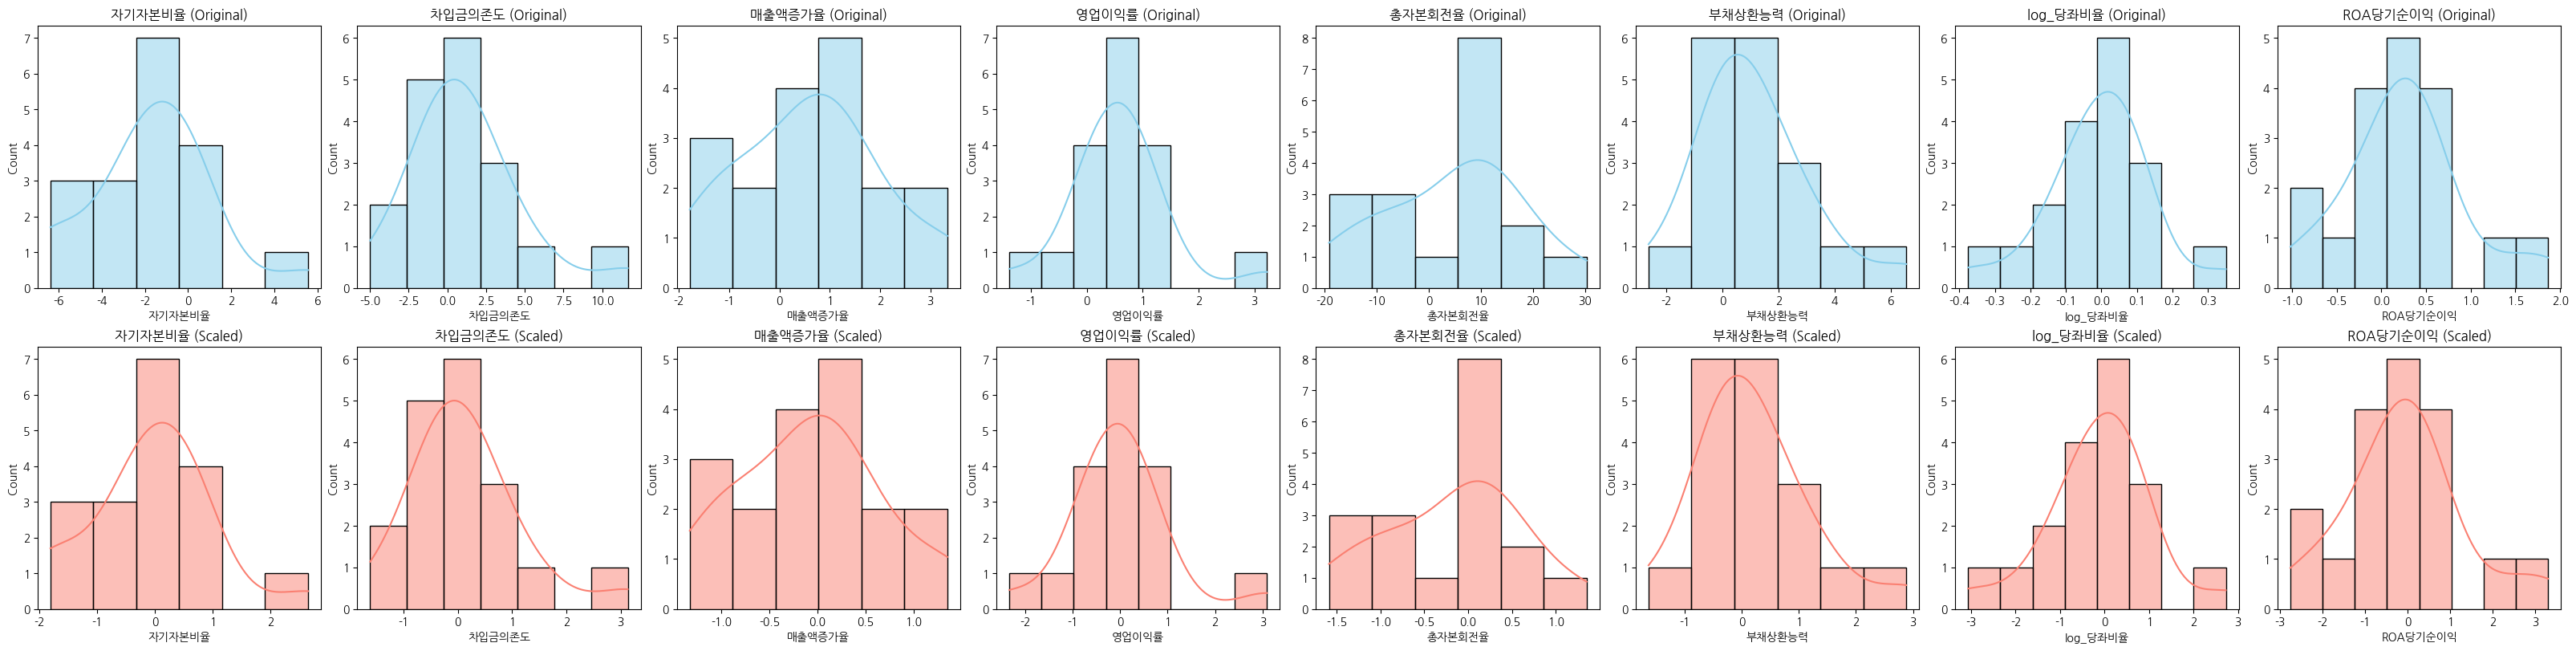

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 2. 각 변수별 분포를 전/후로 비교하는 시각화 코드
# 변수 개수
cols = df_beta.columns
n_cols = len(cols)

# Figure와 subplot 생성 (2행: 1행은 원본, 2행은 표준화 후)
fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(4*n_cols, 8), constrained_layout=True)

for i, col in enumerate(cols):
    # 원본 데이터 분포 (상단)
    sns.histplot(df_beta[col], kde=True, ax=axes[0, i], color='skyblue')
    axes[0, i].set_title(f'{col} (Original)')

    # 표준화된 데이터 분포 (하단)
    sns.histplot(df_beta_scaled[col], kde=True, ax=axes[1, i], color='salmon')
    axes[1, i].set_title(f'{col} (Scaled)')

# 전체 플롯 출력
plt.show()


# 계층적 클러스터링

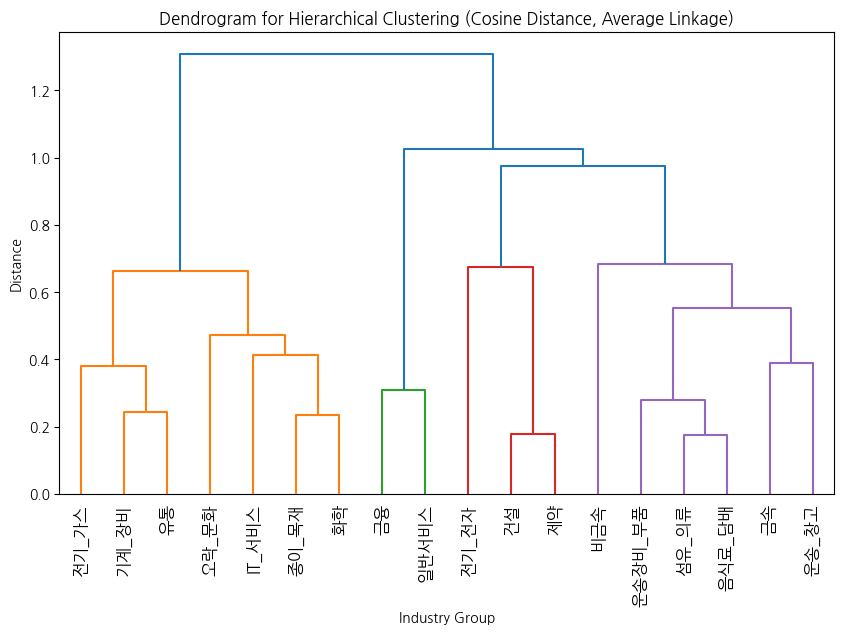

In [36]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# 코사인 거리 행렬 계산 (df_beta_scaled는 클러스터링에 사용할 데이터)
cosine_distances = pdist(df_beta_scaled, metric='cosine')

# 코사인 거리를 사용하여 계층적 클러스터링 수행 (average linkage 사용)
linkage_matrix = linkage(cosine_distances, method='average')

# 덴드로그램 시각화
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, leaf_rotation=90, labels=df_beta_scaled.index)
plt.title("Dendrogram for Hierarchical Clustering (Cosine Distance, Average Linkage)")
plt.xlabel("Industry Group")
plt.ylabel("Distance")
plt.show()

군집 개수 정하는 지표

n_clusters = 2, silhouette score = 0.4262
n_clusters = 3, silhouette score = 0.3709
n_clusters = 4, silhouette score = 0.4502
n_clusters = 5, silhouette score = 0.3520
n_clusters = 6, silhouette score = 0.3320


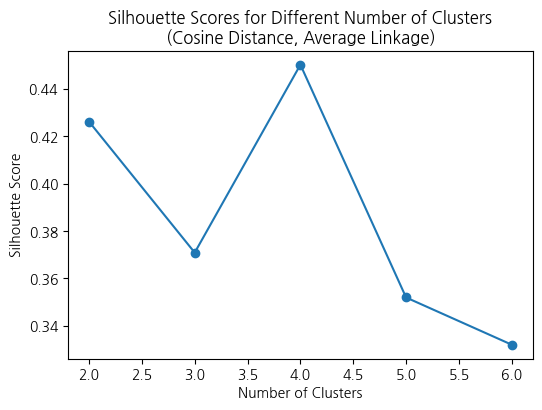

In [37]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
cluster_range = range(2, 7)

for n_clusters in cluster_range:
    # 'affinity' 대신 'metric'을 사용합니다.
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    cluster_labels = clustering.fit_predict(df_beta_scaled)

    # silhouette_score 계산 시 metric='cosine' 지정
    score = silhouette_score(df_beta_scaled, cluster_labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"n_clusters = {n_clusters}, silhouette score = {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Number of Clusters\n(Cosine Distance, Average Linkage)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


# 시각화

In [38]:
from sklearn.cluster import AgglomerativeClustering

# 4개의 군집으로 코사인 거리를 사용하여 average linkage 기반 계층적 클러스터링 수행
clustering = AgglomerativeClustering(n_clusters=4, metric='cosine', linkage='average')
cluster_labels = clustering.fit_predict(df_beta_scaled)

# 클러스터 라벨을 df_beta_scaled 데이터프레임에 'cluster' 열로 추가
df_beta_scaled['cluster'] = cluster_labels

# 결과 확인
print(df_beta_scaled)

           자기자본비율    차입금의존도    매출액증가율     영업이익률    총자본회전율    부채상환능력  log_당좌비율  \
업종                                                                              
IT_서비스  -0.347381 -0.022014 -1.011320 -0.673756  1.351377  0.265121 -0.980421   
건설       0.199163  0.003823 -0.408447 -0.033771 -0.769466 -0.285760 -0.023875   
금속       0.307698 -0.546152  0.088166  0.130776  0.359158  1.575482  0.281417   
금융       0.809334 -0.659287  0.103386 -2.330154  0.040162  0.006133  2.727287   
기계_장비   -1.808590  0.946484 -0.360218 -0.385162  0.783238 -0.493371 -1.000942   
비금속     -0.584617  0.840462  1.258901  3.089891 -0.067237  1.156543 -0.276026   
섬유_의류    2.652665 -1.616000  0.631089  1.019803 -1.424850  2.880337  0.839731   
오락_문화   -0.670145  0.581788 -1.332363  0.162168  0.669050  0.893058  0.413445   
운송_창고   -0.199163 -0.287385 -0.823440  0.477134 -0.040162  0.649823  0.428360   
운송장비_부품  0.500605 -0.590708 -0.026155 -0.183994 -0.899521  0.345204  0.670517   
유통      -0.266719  0.239525 

In [40]:
# 클러스터별 결과 확인
df_beta_scaled.groupby("cluster").apply(lambda x: x.index.tolist())

<ipython-input-40-481bebac22a5>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_beta_scaled.groupby("cluster").apply(lambda x: x.index.tolist())


,0
cluster,
0,"[금속, 비금속, 섬유_의류, 운송_창고, 운송장비_부품, 음식료_담배]"
1,"[건설, 전기_전자, 제약]"
2,"[금융, 일반서비스]"
3,"[IT_서비스, 기계_장비, 오락_문화, 유통, 전기_가스, 종이_목재, 화학]"


In [41]:
#p값 데이터프레임 불러와서 저장

# CSV 파일 불러오기
df_p = pd.read_csv('/content/drive/MyDrive/DSL/EDA/산업별_p값_final.csv', index_col=0)

# 인덱스 변경: "df_코스피_"를 제거
df_p.index = df_p.index.str.replace("df_코스피_", "")

# 결과 확인
print(df_p)

           자기자본비율    차입금의존도    매출액증가율     영업이익률    총자본회전율    부채상환능력  log_당좌비율  \
업종                                                                              
IT_서비스   0.051232  0.732692  0.582348  0.973863  0.058864  0.607057  0.127110   
건설       0.665093  0.694555  0.986243  0.209040  0.683197  0.937973  0.929928   
금속       0.719123  0.313666  0.328234  0.122633  0.173984  0.000900  0.374121   
금융       0.866902  0.684015  0.779446  0.205897  0.270696  0.775048  0.154148   
기계_장비    0.013494  0.023950  0.945303  0.622769  0.062710  0.773907  0.143830   
비금속      0.212656  0.083047  0.082418  0.000189  0.466328  0.068504  0.761209   
섬유_의류    0.004605  0.012844  0.178318  0.000563  0.381914  0.000002  0.064328   
오락_문화    0.269927  0.318963  0.248405  0.692047  0.104151  0.370402  0.291970   
운송_창고    0.475104  0.904869  0.655657  0.418523  0.782177  0.065622  0.527895   
운송장비_부품  0.908944  0.329755  0.417589  0.235985  0.336122  0.229902  0.043646   
유통       0.073477  0.248478 

In [42]:
df_p_with_cluster = df_p.join(df_beta_scaled[['cluster']])
print(df_p_with_cluster)

           자기자본비율    차입금의존도    매출액증가율     영업이익률    총자본회전율    부채상환능력  log_당좌비율  \
업종                                                                              
IT_서비스   0.051232  0.732692  0.582348  0.973863  0.058864  0.607057  0.127110   
건설       0.665093  0.694555  0.986243  0.209040  0.683197  0.937973  0.929928   
금속       0.719123  0.313666  0.328234  0.122633  0.173984  0.000900  0.374121   
금융       0.866902  0.684015  0.779446  0.205897  0.270696  0.775048  0.154148   
기계_장비    0.013494  0.023950  0.945303  0.622769  0.062710  0.773907  0.143830   
비금속      0.212656  0.083047  0.082418  0.000189  0.466328  0.068504  0.761209   
섬유_의류    0.004605  0.012844  0.178318  0.000563  0.381914  0.000002  0.064328   
오락_문화    0.269927  0.318963  0.248405  0.692047  0.104151  0.370402  0.291970   
운송_창고    0.475104  0.904869  0.655657  0.418523  0.782177  0.065622  0.527895   
운송장비_부품  0.908944  0.329755  0.417589  0.235985  0.336122  0.229902  0.043646   
유통       0.073477  0.248478 

In [45]:
# 클러스터 재매핑 딕셔너리 생성
# (지니 언니랑 클러스터 결과 똑같이 해서 시각화하기 위해)

mapping = {1: 3, 2: 1, 3: 2, 4: 4}

# df_beta_scaled의 'cluster' 열 재매핑
df_beta_scaled['cluster'] = df_beta_scaled['cluster'].replace(mapping)

# 만약 df_p에도 클러스터 정보가 포함되어 있다면, 동일하게 업데이트 (예: df_p_with_cluster)
df_p_with_cluster['cluster'] = df_p_with_cluster['cluster'].replace(mapping)

In [46]:
df_beta_scaled.groupby("cluster").apply(lambda x: x.index.tolist())

<ipython-input-46-b77e43ec8c14>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_beta_scaled.groupby("cluster").apply(lambda x: x.index.tolist())


,0
cluster,
0,"[금속, 비금속, 섬유_의류, 운송_창고, 운송장비_부품, 음식료_담배]"
1,"[건설, 전기_전자, 제약]"
2,"[금융, 일반서비스]"
3,"[IT_서비스, 기계_장비, 오락_문화, 유통, 전기_가스, 종이_목재, 화학]"


# 산업별 p-value 분포 확인

<ipython-input-48-b9bd1b086afb>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-48-b9bd1b086afb>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-48-b9bd1b086afb>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-48-b9bd1b086afb>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


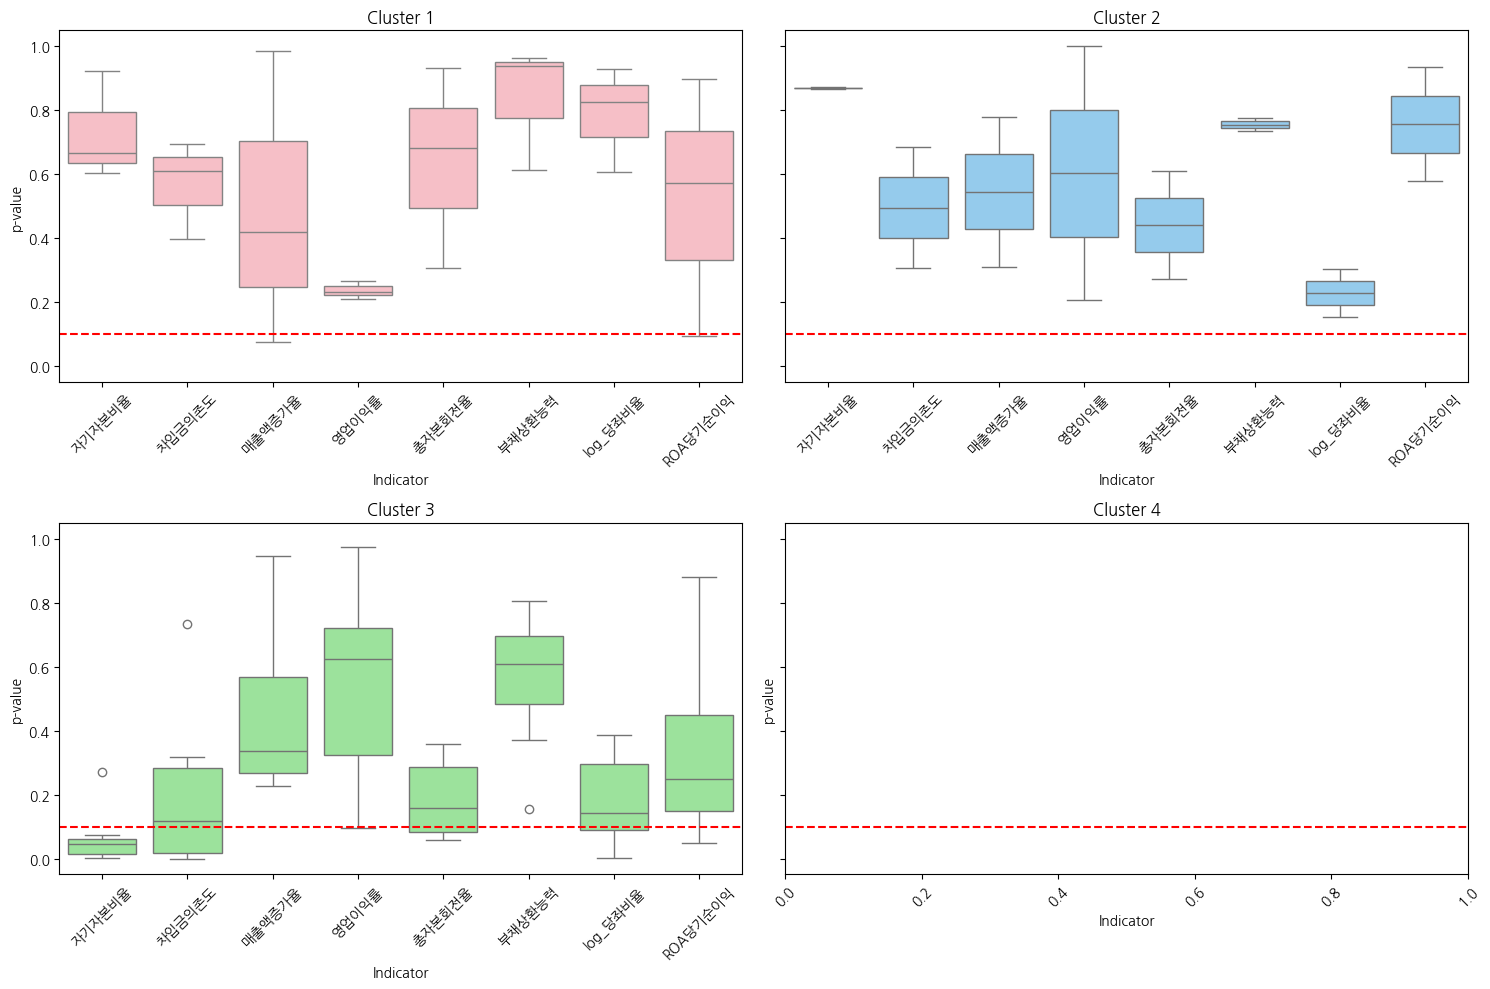

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# (전제) df_p_with_cluster에는 산업별 p‑값과 'cluster' 열이 있음.
# 'cluster' 열을 문자열로 변환 (예: "1", "2", "3", "4")
df_p_with_cluster['cluster'] = df_p_with_cluster['cluster'].astype(str)

# 클러스터 순서를 지정 (1, 2, 3, 4)
clusters_order = ["1", "2", "3", "4"]

# 8개 재무지표 목록 (df_p의 컬럼들)
indicators = df_p.columns.tolist()  # 예: ['자기자본비율', '차입금의존도', ..., 'ROA당기순이익']

# 클러스터별 사용자 지정 색상 (각 서브플롯 내 박스플롯 모두 같은 색)
custom_palette = {"1": "#FFB6C1", "2": "#87CEFA", "3": "#90EE90", "4": "#D8BFD8"}

# 2행 2열 서브플롯 (총 4개 클러스터)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

# 각 클러스터별로 박스플롯 그리기
for i, cl in enumerate(clusters_order):
    ax = axes[i // 2, i % 2]
    # 해당 클러스터에 해당하는 행만 필터링
    df_cluster = df_p_with_cluster[df_p_with_cluster['cluster'] == cl]

    # wide 형식을 long 형식으로 변환: 재무지표 컬럼들을 'Indicator', 'p_value'로 melt
    df_melt = pd.melt(df_cluster,
                      id_vars=["cluster"],
                      value_vars=indicators,
                      var_name="Indicator",
                      value_name="p_value")

    # 박스플롯 그리기: x축은 Indicator, y축은 p_value.
    sns.boxplot(data=df_melt, x="Indicator", y="p_value", color=custom_palette[cl], ax=ax)

    # p-value 기준선 (y = 0.1) 추가
    ax.axhline(y=0.1, color='red', linestyle='--', linewidth=1.5)

    ax.set_title(f"Cluster {cl}")
    ax.set_xlabel("Indicator")
    ax.set_ylabel("p-value")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# p-value < 0.1인 베타의 평균값 그래프

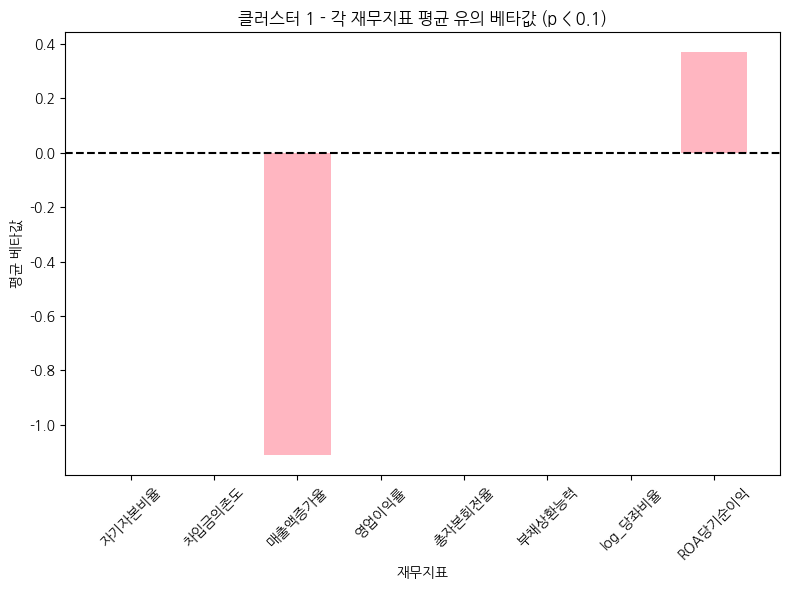

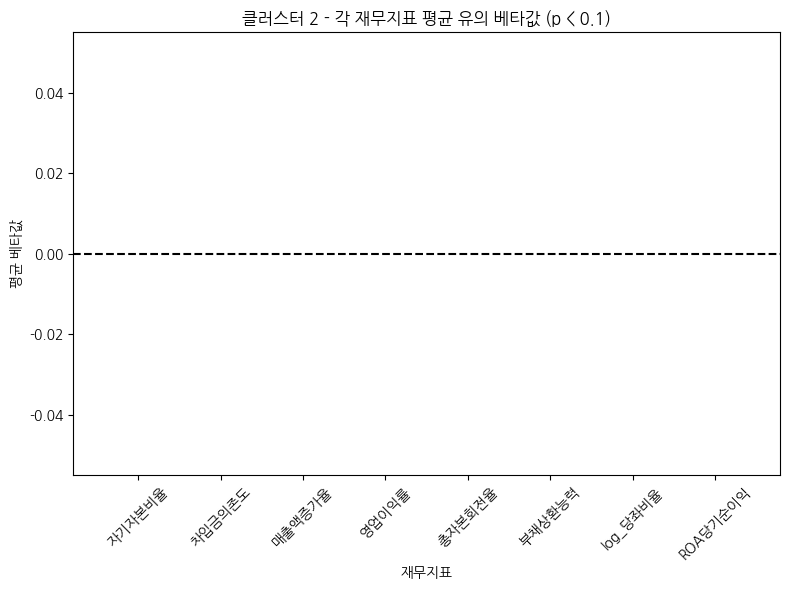

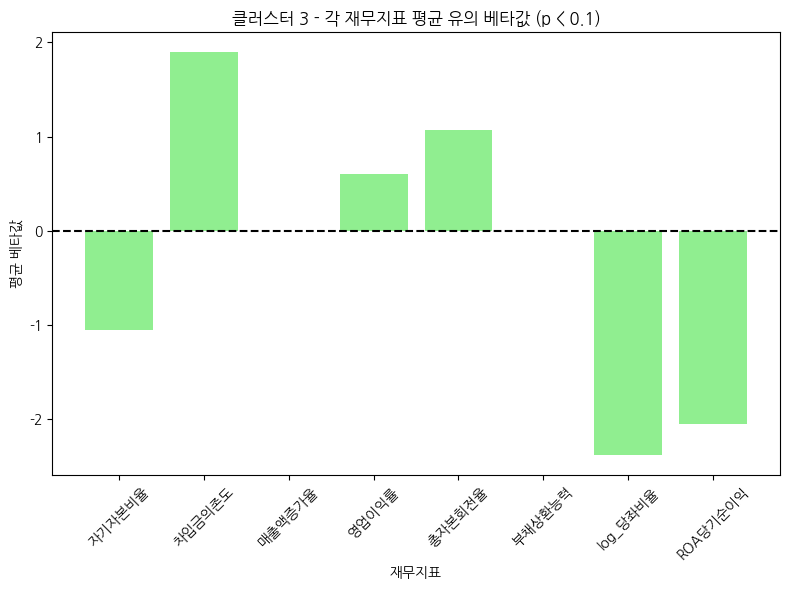

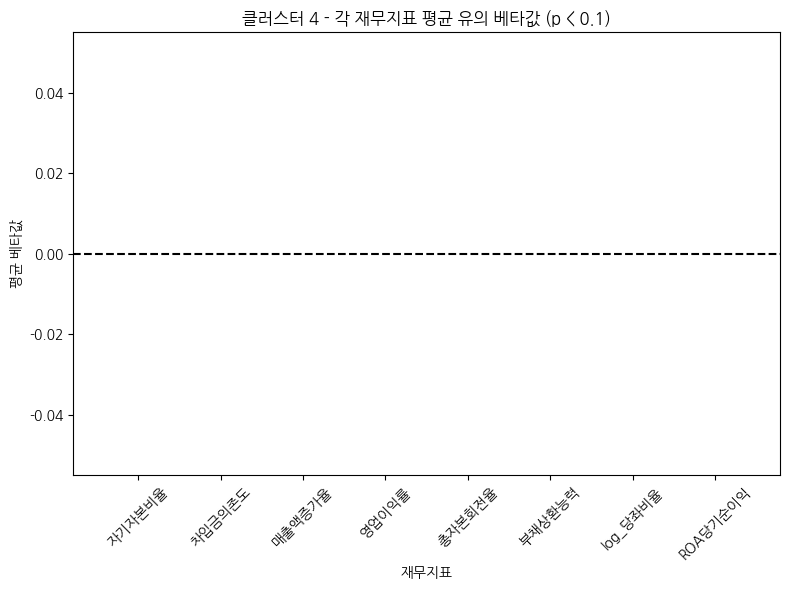

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# 클러스터별 색상 지정
# 클러스터 1: 연핑크, 2: 하늘, 3: 연녹색, 4: 연보라
custom_palette = {1: "#FFB6C1", 2: "#87CEFA", 3: "#90EE90", 4: "#D8BFD8"}

# 먼저, df_beta_scaled의 'cluster' 열이 정수형인지 확인
df_beta_scaled['cluster'] = df_beta_scaled['cluster'].astype(int)

# 클러스터 목록 (1,2,3,4)
clusters = [1, 2, 3, 4]
# 재무지표 목록 (df_p의 컬럼들; 예: ['자기자본비율', '차입금의존도', ... , 'ROA당기순이익'])
indicators = df_p.columns.tolist()

# 결과를 저장할 DataFrame: 행=재무지표, 열=클러스터
# 각 셀에는 해당 재무지표에 대해 p-value가 0.1 미만인 경우의 평균 베타값이 저장됨.
result = pd.DataFrame(index=indicators, columns=clusters)

# 각 재무지표에 대해 계산 (df_beta_scaled와 df_p를 결합)
for indicator in indicators:
    # df_beta_scaled에서 해당 재무지표와 'cluster', 그리고 df_p에서 해당 재무지표의 p-value를 결합
    df_temp = df_beta_scaled[[indicator, 'cluster']].join(df_p[[indicator]], rsuffix='_p')
    # 'cluster' 열을 정수형으로 확실히 변환
    df_temp['cluster'] = df_temp['cluster'].astype(int)
    # p-value가 0.1 미만인 데이터만 선택
    df_temp_sig = df_temp[df_temp[f"{indicator}_p"] < 0.1]
    # 클러스터별로 평균 베타값 계산
    group_means = df_temp_sig.groupby('cluster')[indicator].mean()
    # 각 클러스터에 대해 결과를 저장 (해당 클러스터에 데이터가 없으면 0으로)
    for cl in clusters:
        result.loc[indicator, cl] = group_means.get(cl, 0)

# 결과 DataFrame의 데이터형식을 숫자로 변환
result = result.apply(pd.to_numeric)

# 이제 각 클러스터별로 막대그래프 그림
# 각 그래프는 x축에 8개 재무지표(인덱스)를, y축에 해당 클러스터의 평균 베타값을 표시
for cl in clusters:
    plt.figure(figsize=(8, 6))
    # 막대그래프: x축은 재무지표, y축은 result[cl] (해당 클러스터의 값)
    plt.bar(result.index, result[cl], color=custom_palette[cl])
    # y=0 기준 선 추가 (검정 점선)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    plt.title(f"클러스터 {cl} - 각 재무지표 평균 유의 베타값 (p < 0.1)")
    plt.xlabel("재무지표")
    plt.ylabel("평균 베타값")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()